In [94]:
# thư viện 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import pandas as pd
from wordcloud import WordCloud

# Nhập dữ liệu 

In [95]:
from processor_layer.loader import DataLoader
from config import Config
loader = DataLoader(Config.DATA_FILE)
loader.load_data()
loader.review_data

[2025-12-09 23:30:55] [INFO] Tải dữ liệu từ: d:\HK1 NĂM 3\PYTHON FOR DATA SCIENCE\Emo-Classification\data\data.xlsx
[2025-12-09 23:30:55] [INFO] Đang đọc dữ liệu từ file d:\HK1 NĂM 3\PYTHON FOR DATA SCIENCE\Emo-Classification\data\data.xlsx
[2025-12-09 23:30:55] [INFO] Tải dữ liệu thành công! Số dòng: 6241
[2025-12-09 23:30:55] [INFO] Xem trước 5 dòng dữ liệu.


,Unnamed: 0,Emotion,Sentence
0,1960,Surprise,y tế 24tr tháng á ???? kinh vầy ???
1,1959,Surprise,list này không có liệt kê công việc của dân ch...
2,1958,Surprise,y tế chăm sóc sức khỏe lương nhiều vậy sao
3,1957,Disgust,"dume lương cao nhất vẫn là các lãnh đạo nhé , ..."
4,1957,Surprise,gì thế này ? này là kiến thức đó hả ?


# Định nghĩa

**Unnamed**: Cột id của những người dùng bình luận\
**Emotion**: Nhãn dán cảm xúc của mỗi bình luận 
- Sadness: Buồn bã
- Disgust: Kinh tởm
- Fear: Sợ hãi
- Anger: Giận dữ 
- Surprise: Ngạc nhiên
- Enjoyment: Hài lòng
- Other: Cảm xúc khác

**Sentence**: Câu bình luận của mỗi id 

In [96]:
data = loader.data.copy()
print(data.head())

   Unnamed: 0   Emotion                                           Sentence
0        1960  Surprise                y tế 24tr tháng á ???? kinh vầy ???
1        1959  Surprise  list này không có liệt kê công việc của dân ch...
2        1958  Surprise         y tế chăm sóc sức khỏe lương nhiều vậy sao
3        1957   Disgust  dume lương cao nhất vẫn là các lãnh đạo nhé , ...
4        1957  Surprise              gì thế này ? này là kiến thức đó hả ?


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6241 entries, 0 to 6240
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6241 non-null   int64 
 1   Emotion     6241 non-null   object
 2   Sentence    6241 non-null   object
dtypes: int64(1), object(2)
memory usage: 146.4+ KB


Nhóm nhận thấy dữ liệu có 6241 giá trị, trong đó không có giá trị khuyết

In [98]:
# tách dữ liệu 
cate_data = data.select_dtypes(include= ['object']) 
num_data = data.select_dtypes(include= ['number'])

In [99]:
print(cate_data.columns.tolist()) # lấy những feature object

['Emotion', 'Sentence']


# Kiểm tra dữ liệu tổng quan

## Độ dài chuỗi

In [100]:
# kiểm tra độ dài của bình luận 
len_sentence = cate_data['Sentence'].apply(len)
len_sentence.head()

0     35
1     61
2     42
3    110
4     37
Name: Sentence, dtype: int64

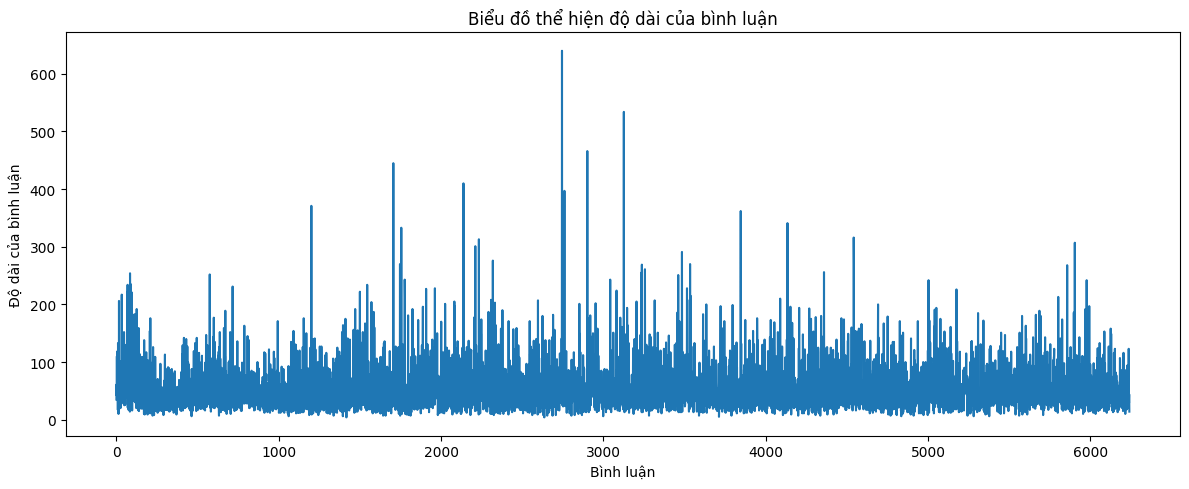

In [101]:
# kiểm tra có dòng bình luận nào quá ngắn hay quá dài không 
plt.figure(figsize=(12,5))
plt.plot(len_sentence)
plt.xlabel("Bình luận")
plt.ylabel("Độ dài của bình luận")
plt.title("Biểu đồ thể hiện độ dài của bình luận")
plt.tight_layout()
plt.show()

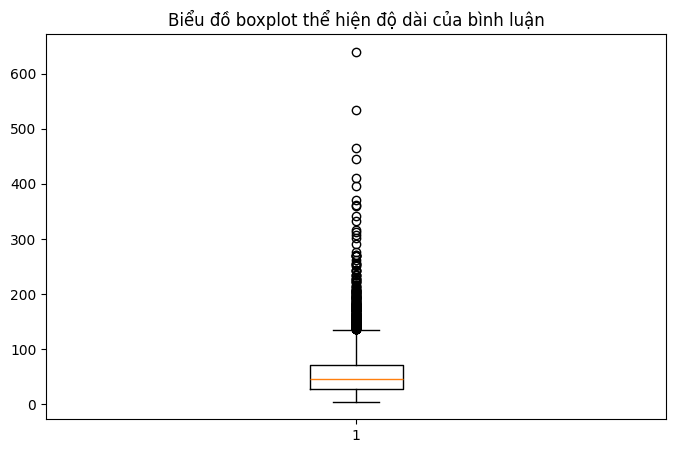

In [102]:
plt.figure(figsize=(8,5))
plt.boxplot(len_sentence)
plt.title("Biểu đồ boxplot thể hiện độ dài của bình luận")
plt.show()

In [103]:
len_sentence = cate_data['Sentence'].apply(len)
print(f"Bình luận ngắn nhất là:\n{cate_data[len_sentence == min(len_sentence)]} \nvới độ dài là {min(len_sentence)}")
print(f"Bình luận dài nhất là: \n{cate_data[len_sentence == max(len_sentence)]} \nvới độ dài là {max(len_sentence)}")

Bình luận ngắn nhất là:
      Emotion Sentence
1417    Anger     immm
2636  Disgust     điên 
với độ dài là 4
Bình luận dài nhất là: 
      Emotion                                           Sentence
2745  Disgust  tôi kể các bạn nghe 1 chuyện có dính 1 tý với ... 
với độ dài là 640


### Nhận xét:
Ta thấy bình luận có độ dài mỗi câu không tương đồng, tuy nhiên mỗi câu đều mang ý nghĩa cảm xúc nên ta không cần loại bỏ (điên, im,..).

## Nhãn

In [104]:
# kiểm tra nhãn
cate_data['Emotion'].unique().tolist()

['Surprise', 'Disgust', 'Anger', 'Enjoyment', 'Fear', 'Sadness', 'Other']

In [105]:
cate_data['Emotion'].value_counts(normalize=True) * 100

Emotion
Enjoyment    28.056401
Disgust      19.275757
Other        18.426534
Sadness      17.032527
Anger         6.905945
Fear          5.832399
Surprise      4.470437
Name: proportion, dtype: float64

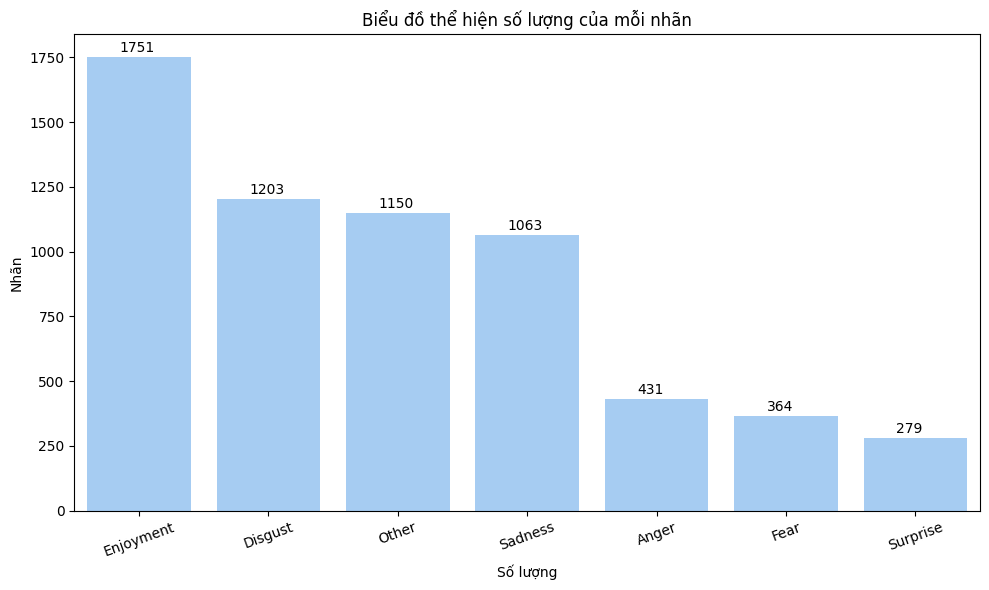

In [106]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=data, x='Emotion', order=data['Emotion'].value_counts().index, color='#99CCFF')
plt.title("Biểu đồ thể hiện số lượng của mỗi nhãn")
plt.xlabel("Số lượng")
plt.ylabel("Nhãn")
plt.xticks(rotation=20)
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + 0.25, p.get_height() + 20))
plt.tight_layout()
plt.show()

### Nhận xét:
số lượng của mỗi nhãn dán không đều, enjoyment chiếm số lượng lớn ~1750 nhưng surprise chiếm số lượng tương đối nhỏ ~250\
=> mô hình học có khả năng không đều -> nhóm thực hiện ghép nhãn dữ liệu thành 3 lớp: Tích cực, Tiêu cực, Trung tính để mô hình học được tốt hơn (có thể cải tiến sau này nếu muốn phân loại thành nhiều nhãn)

In [107]:
def merge_label(data):
    """Gộp nhãn dữ liệu thành Tích cực / Tiêu cực / Trung tính"""
    def mapper(label):
        if label in ['Enjoyment', 'Surprise']:
            return 'Tích cực'
        elif label in ['Disgust', 'Fear', 'Sadness', 'Anger']:
            return 'Tiêu cực'
        else:
            return 'Trung tính'
    data['new_emotion'] = data['Emotion'].apply(mapper)
    return data
cate_data = merge_label(cate_data)
print("dữ liệu sau khi đã gộp nhãn")
print(cate_data.head())

dữ liệu sau khi đã gộp nhãn
    Emotion                                           Sentence new_emotion
0  Surprise                y tế 24tr tháng á ???? kinh vầy ???    Tích cực
1  Surprise  list này không có liệt kê công việc của dân ch...    Tích cực
2  Surprise         y tế chăm sóc sức khỏe lương nhiều vậy sao    Tích cực
3   Disgust  dume lương cao nhất vẫn là các lãnh đạo nhé , ...    Tiêu cực
4  Surprise              gì thế này ? này là kiến thức đó hả ?    Tích cực


In [111]:
cate_data['Emotion'].value_counts(normalize=True) * 100

Emotion
Enjoyment    28.056401
Disgust      19.275757
Other        18.426534
Sadness      17.032527
Anger         6.905945
Fear          5.832399
Surprise      4.470437
Name: proportion, dtype: float64

In [109]:
cate_data['new_emotion'].value_counts(normalize=True) * 100

new_emotion
Tiêu cực      49.046627
Tích cực      32.526839
Trung tính    18.426534
Name: proportion, dtype: float64

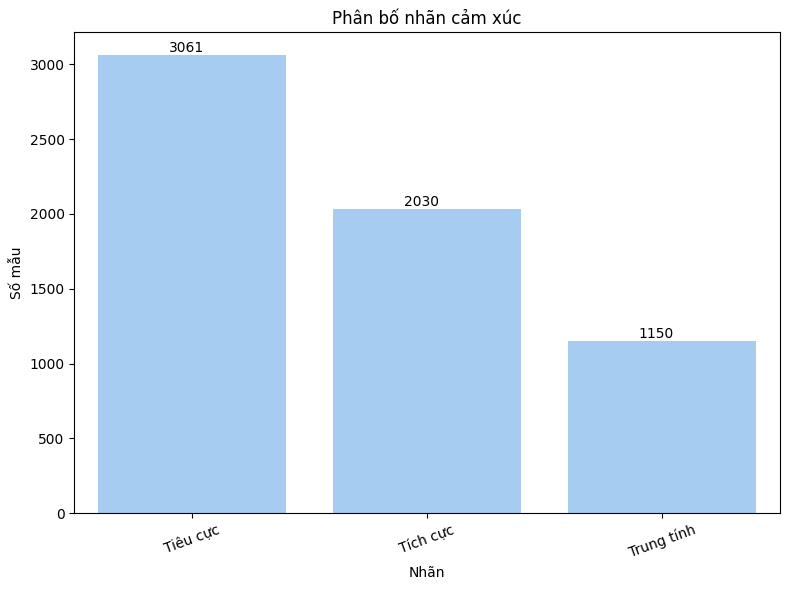

In [112]:
plt.figure(figsize=(8,6))
ax = sns.countplot(data=cate_data, x='new_emotion', order=cate_data['new_emotion'].value_counts().index, color= '#99CCFF')
plt.title("Phân bố nhãn cảm xúc")
plt.xlabel("Nhãn")
plt.ylabel("Số mẫu")
plt.xticks(rotation=20)
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + 0.3, p.get_height() + 20))
plt.tight_layout()
plt.show()

### Nhận xét:
Sau khi gộp nhãn, dữ liệu vẫn đang có sự mất cân bằng giữa các nhãn, cụ thể là nhãn tiêu cực gấp đôi nhãn trung tính:
- Tiêu cực: ~3000
- Tích cực: ~2000
- Trung tính: ~1200

Do chênh lệch về dữ liệu khiến cho mô hình bị thiên vị => cần cân bằng dữ liệu trước khi train mô hình, mô hình có thể học tốt nhãn "Tiêu cực" và học sai dữ liệu nhãn "Trung tính"

## Emoji

In [113]:
emoji_pattern = re.compile("["
    "\U0001F600-\U0001F64F"  # mặt cười
    "\U0001F300-\U0001F5FF"  # biểu tượng
    "\U0001F680-\U0001F6FF"  # xe cộ
    "\U0001F1E0-\U0001F1FF"  # cờ
    "]+", flags=re.UNICODE)

cate_data["emoji"] = cate_data['Sentence'].apply(lambda x: emoji_pattern.findall(x))

In [115]:
# lấy số lượng emoji có trong dữ liệu huấn luyện
emoji = set()
for x in cate_data['emoji']:
    for emo_str in x:         # mỗi phần tử trong x là một chuỗi emoji
        for emo in emo_str:   # lặp từng ký tự
            emoji.add(emo)

print(emoji)
print(len(emoji))

{'🙂', '😜', '😩', '😡', '💋', '😐', '😍', '😚', '😁', '😈', '😏', '😶', '😑', '😕', '😠', '😘', '😿', '😒', '😦', '💕', '🕸', '👍', '😻', '😔', '😉', '😹', '🙎', '😅', '😳', '😬', '💓', '😱', '🌚', '😀', '😆', '🐕', '🌝', '💔', '🌧', '💃', '🙏', '👏', '😪', '😧', '😖', '😌', '😗', '🙄', '😃', '😭', '🐶', '💩', '😫', '😤', '😥', '😋', '😴', '🙃', '😰', '🌸', '🙁', '😓', '😮', '😝', '😣', '😛', '👌', '😢', '🏻', '👻', '😊', '💐', '😄', '👎', '😂', '💪', '😎', '😞', '😨'}
79


In [114]:
def extract_emojis(text: str):
    return emoji_pattern.findall(text)

def emoji_stats(df: pd.DataFrame, text_col="Sentence"):
    all_emojis = []
    for t in df[text_col].astype(str):
        all_emojis.extend(extract_emojis(t))
    counter = Counter(all_emojis)
    print("\nTop 10 emoji xuất hiện nhiều nhất:")
    for emo, cnt in counter.most_common(10):
        print(repr(emo), ":", cnt)
emoji_stats(cate_data)


Top 10 emoji xuất hiện nhiều nhất:
'😂' : 100
'🙂' : 66
'😂😂😂' : 52
'😂😂' : 46
'😌' : 32
'😞' : 31
'😢' : 30
'😭' : 28
'😑' : 23
'🙄' : 17


### Nhận xét:
Trong tập dữ liệu mà nhóm sử dụng, các emoji xuất hiện với tần suất đáng kể và mỗi emoji đều thể hiện một trạng thái cảm xúc nhất định. Do đó, chúng đóng vai trò quan trọng trong quá trình huấn luyện mô hình. Để khai thác thông tin này một cách hiệu quả, nhóm đã xây dựng tệp *emoji_dict.json*, trong đó mỗi emoji được ánh xạ (key) tới nhãn cảm xúc tương ứng (value). Tệp này được sử dụng để thay thế emoji trong văn bản bằng các từ mô tả cảm xúc tương ứng.

## Words 

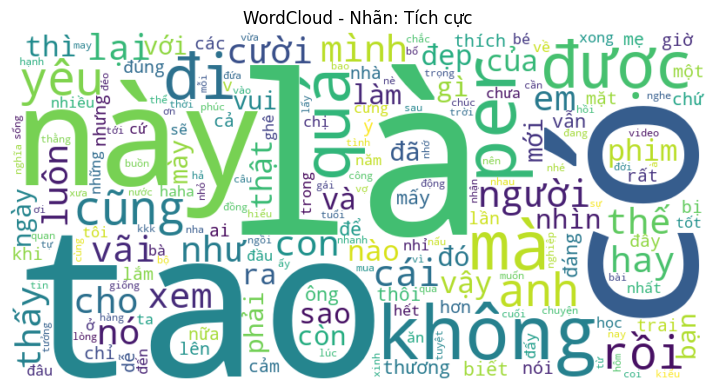

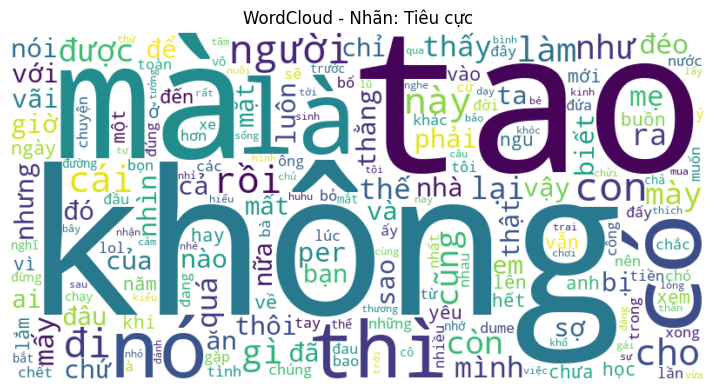

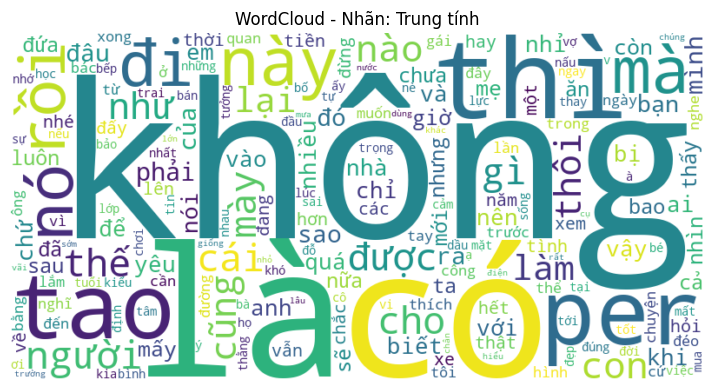

In [116]:
def generate_wordcloud_for_label(df: pd.DataFrame, label_value, text_col="text", label_col="label"):
    text = " ".join(df.loc[df[label_col] == label_value, text_col].astype(str))
    wc = WordCloud(width=800, height=400, background_color="white",
                   collocations=False).generate(text)

    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - Nhãn: {label_value}")
    plt.tight_layout()
    plt.show()
for lbl in cate_data['new_emotion'].unique():
        generate_wordcloud_for_label(cate_data, lbl, 'Sentence', 'new_emotion')

### Nhận xét:
Đối với nhãn tích cực: Ngoài những đại từ nhân xưng, từ "có" xuất hiện nhiều thì còn một số từ khác như: "yêu", "cười", "thích", "cưng",.. thể hiện cảm xúc tích cực 

Đối với nhãn tiêu cực: từ "không" xuất hiện nhiều nhất thể hiện cảm xúc phản đối, bên cạnh đó, xuất hiện một số từ mang nghĩa tiêu cực nhưng không quá nhiều từ

Đối với nhãn trung tính: từ "không" xuất hiện gần như nhiều nhất, bên cạnh đó là từ "có", nhưng mà cũng xuất hiện các thể hiện cảm xúc tích cực: "yêu", "tình",.., còn lại hầu như là các từ không mang tầng lớp ý nghĩa nhiều

=> mô hình có thể đoán lệch nhãn do sự khác biệt giữa các nhãn là không nhiều